# Demo de Denoising Diffusion Model (DDM) para generar imágenes
Basado en: https://keras.io/examples/generative/ddim/

In [1]:
#@title Librerías a usar
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import math
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras import layers
from keras import ops

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import pandas as pd


import random
import copy
import os

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import display

from PIL import Image

print("\nLibrerías importadas")


Librerías importadas


# Imágenes:

In [2]:
#@title Acceder al Drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/NUMEROS' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_validacion = '/test'  #@param {type:"string"}
#@markdown - Nota: se usan las imágenes de Prueba como de Validación durante el entrenamiento.


imagPath_train = path + path_entrenamiento
imagPath_val = path + path_validacion

Mounted at /content/gdrive


In [3]:
#@title Cargar imágenes usando Data pipeline
# adaptado con https://www.tensorflow.org/tutorials/load_data/images?hl=es-419

def preprocess_image(ImData):
    # center crop image
    height = ops.shape(ImData)[0]
    width = ops.shape(ImData)[1]
    crop_size = ops.minimum(height, width)
    imageCrop = tf.image.crop_to_bounding_box(
         ImData,
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )
    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    imageResize = tf.image.resize(imageCrop, size=[image_size, image_size], antialias=True)
    return ops.clip(imageResize / 255.0, 0.0, 1.0)


def prepare_dataset(imagePath):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
          # carga imágenes de dirctorios
          tf.keras.utils.image_dataset_from_directory(
              imagePath,
              batch_size=None,
              shuffle=True)
            # se decarta la clase y se ajustan las imágense
            .map((lambda im, cl: (preprocess_image(im))), num_parallel_calls=tf.data.AUTOTUNE)
            .cache()
            # genera repeticiones y desordena
            .repeat(dataset_repetitions)
            .shuffle(10 * batch_size)
            # fuerza generación de batches
            .batch(batch_size, drop_remainder=True)
            .prefetch(buffer_size=tf.data.AUTOTUNE)
          )


# parametros
dataset_repetitions = 5
image_size = 64
batch_size = 64

print("\n > Entrenamiento: ")
train_dataset = prepare_dataset(imagPath_train)

print("\n > Validación: ")
val_dataset = prepare_dataset(imagPath_val)



 > Entrenamiento: 
Found 240 files belonging to 10 classes.

 > Validación: 
Found 60 files belonging to 10 classes.


Imágenes disponibles:  (64, 64, 64, 3)


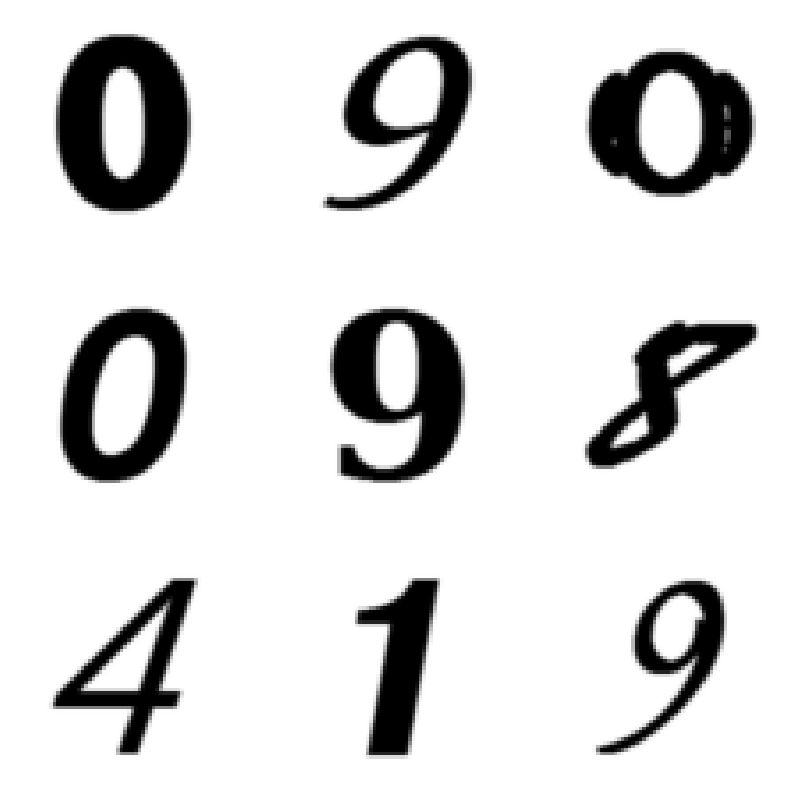

In [4]:
#@title Mostrar ejemplos de imágenes de Entrenamiento
import matplotlib.pyplot as plt


for imagesTrain in train_dataset.take(1):
  print("Imágenes disponibles: ", imagesTrain.shape)

plt.figure(figsize=(10, 10))
for i in range(min(9,imagesTrain.shape[0])):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow((imagesTrain[i].numpy()*255.0).astype("uint8"))
  plt.axis("off")


# Modelo:

In [31]:
#@title Definir DMM

# parámetros
## KID
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

## sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

## architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

## optimization
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

# others
path_train_images = "/content/training_images"

# Kernel inception distance (KID) for image quality metric

@keras.saving.register_keras_serializable()
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = ops.cast(ops.shape(features_1)[1], dtype="float32")
        return (
            features_1 @ ops.transpose(features_2) / feature_dimensions + 1.0
        ) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = real_features.shape[0]
        batch_size_f = ops.cast(batch_size, dtype="float32")
        mean_kernel_real = ops.sum(kernel_real * (1.0 - ops.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = ops.sum(
            kernel_generated * (1.0 - ops.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = ops.mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

print("\nKID definido.")

# arquitectura para red U-NET
@keras.saving.register_keras_serializable()
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = ops.exp(
        ops.linspace(
            ops.log(embedding_min_frequency),
            ops.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = ops.cast(2.0 * math.pi * frequencies, "float32")
    embeddings = ops.concatenate(
        [ops.sin(angular_speeds * x), ops.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation="swish")(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding, output_shape=(1, 1, 32))(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")

print("\nU-Net definida.")

@keras.saving.register_keras_serializable()
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth, path_train_images=None):
        super().__init__()
        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)
        self.path_train_images = path_train_images

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    def show_model(self):
      print("")
      self.network.summary()
      ##print("")
      ##tf.keras.utils.plot_model(self.network, show_layer_names=True, show_shapes=True)
      print("")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return ops.clip(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = ops.cast(ops.arccos(max_signal_rate), "float32")
        end_angle = ops.cast(ops.arccos(min_signal_rate), "float32")

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = ops.cos(diffusion_angles)
        noise_rates = ops.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = ops.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = keras.random.normal(
            shape=(num_images, image_size, image_size, 3)
        )
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = keras.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = keras.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = keras.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = keras.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps
        )
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}


    def generate_images(self, quantity=9):
      # define columnas y filas
      if (quantity%2)==0:
        cols = 2
      elif (quantity%3)==0:
        cols = 3
      else:
        cols = quantity
      rows = quantity//cols
      # genera imágenes
      return self.plot_images(epoch=None, logs=None, num_rows=rows, num_cols=cols)

    def plot_images(self, epoch=None, logs=None, num_rows=2, num_cols=5):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )
        f = plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        if (self.path_train_images is None) or (epoch is None):
          # muestra la imagen
          plt.show()
        else:
          # si no existe el directorio, lo crea
          if not os.path.isdir(self.path_train_images):
            os.makedirs(self.path_train_images)
          # graba la imagen
          plt.title("Epoch #"+str(epoch+1), fontsize=11 )
          fn = self.path_train_images + "/grid_epoch_{epoch:05}.png".format(epoch=epoch)
          f.savefig(fn)
        plt.close()



# create and compile the model
model = DiffusionModel(image_size, widths, block_depth, path_train_images)

# below tensorflow 2.9:
# pip install tensorflow_addons
# import tensorflow_addons as tfa
# optimizer=tfa.optimizers.AdamW
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# pixelwise mean absolute error is used as loss

print("\nDiffusion Model definido.")


KID definido.

U-Net definida.

Diffusion Model definido.


In [32]:
#@title Muestra modelo U-Net
tf.keras.utils.plot_model(model.network, show_layer_names=True, show_shapes=True)
print("")
model.show_model()

Model: "residual_unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 1, 1, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_12            │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 1, 1, 32)       │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_402 (Conv2D)       │ (None, 64, 64, 32)     │            128 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_12          │ (None, 64, 64, 32)     │              0 │ lambda_6[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_27            │ (None, 64, 64, 64)     │              0 │ conv2d_402[0][0],      │
│ (Concatenate)             │                        │                │ up_sampling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_324   │ (None, 64, 64, 64)     │            128 │ concatenate_27[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_404 (Conv2D)       │ (None, 64, 64, 32)     │         18,464 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_405 (Conv2D)       │ (None, 64, 64, 32)     │          9,248 │ conv2d_404[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_403 (Conv2D)       │ (None, 64, 64, 32)     │          2,080 │ concatenate_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_42 (Add)              │ (None, 64, 64, 32)     │              0 │ conv2d_405[0][0],      │
│                           │                        │                │ conv2d_403[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_325   │ (None, 64, 64, 32)     │             64 │ add_42[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_406 (Conv2D)       │ (None, 64, 64, 32)     │          9,248 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_407 (Conv2D)       │ (None, 64, 64, 32)     │          9,248 │ conv2d_406[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_43 (Add)              │ (None, 64, 64, 32)     │              0 │ conv2d_407[0][0],      │
│                           │                        │                │ add_42[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_36 

 Total params: 1,953,507 (7.45 MB)

 Trainable params: 1,950,627 (7.44 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [33]:
#@title Entrenar DDM

cant_epocas_entrenamiento = 500 #@param {type:"integer"}


# cantidad de épocas del entrenamiento
cantEpocas = (1 if cant_epocas_entrenamiento<1 else cant_epocas_entrenamiento)

# save the best model based on the validation KID metric
best_checkpoint_path = "checkpoints/diffusion_model.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=best_checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

# Start training
print("\n\n>Comienza el Entrenamiento:")

# run training and plot generated images periodically
history = model.fit(
    train_dataset,
    epochs=cant_epocas_entrenamiento,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

# graba ultimo modelo
last_checkpoint_path = 'checkpoints/last_diffusion_model.weights.h5'
model.save_weights(last_checkpoint_path)

print("\n>Entrenamiento Finalizado.")



>Comienza el Entrenamiento:
Epoch 1/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - i_loss: 2.3058 - n_loss: 0.7295 - val_i_loss: 2.2919 - val_kid: 2.3579 - val_n_loss: 0.7983
Epoch 2/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 417ms/step - i_loss: 0.7564 - n_loss: 0.2972 - val_i_loss: 1.9295 - val_kid: 2.3874 - val_n_loss: 0.7982
Epoch 3/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 433ms/step - i_loss: 0.4777 - n_loss: 0.1785 - val_i_loss: 2.7696 - val_kid: 2.4637 - val_n_loss: 0.7983
Epoch 4/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 410ms/step - i_loss: 0.3745 - n_loss: 0.1481 - val_i_loss: 2.1152 - val_kid: 2.5028 - val_n_loss: 0.7981
Epoch 5/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 363ms/step - i_loss: 0.3483 - n_loss: 0.1383 - val_i_loss: 2.3588 - val_kid: 2.5011 - val_n_loss: 0.7979
Epoch 6/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 409ms/step - i_loss: 0.3049 - n_loss: 0.1275 - val_i_loss: 2.3045 - val_kid: 2.5163 - val_n_loss: 0.7986
Epoch 7/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 364ms/step - i_loss: 0.2797 - n_loss: 0.1184 - v

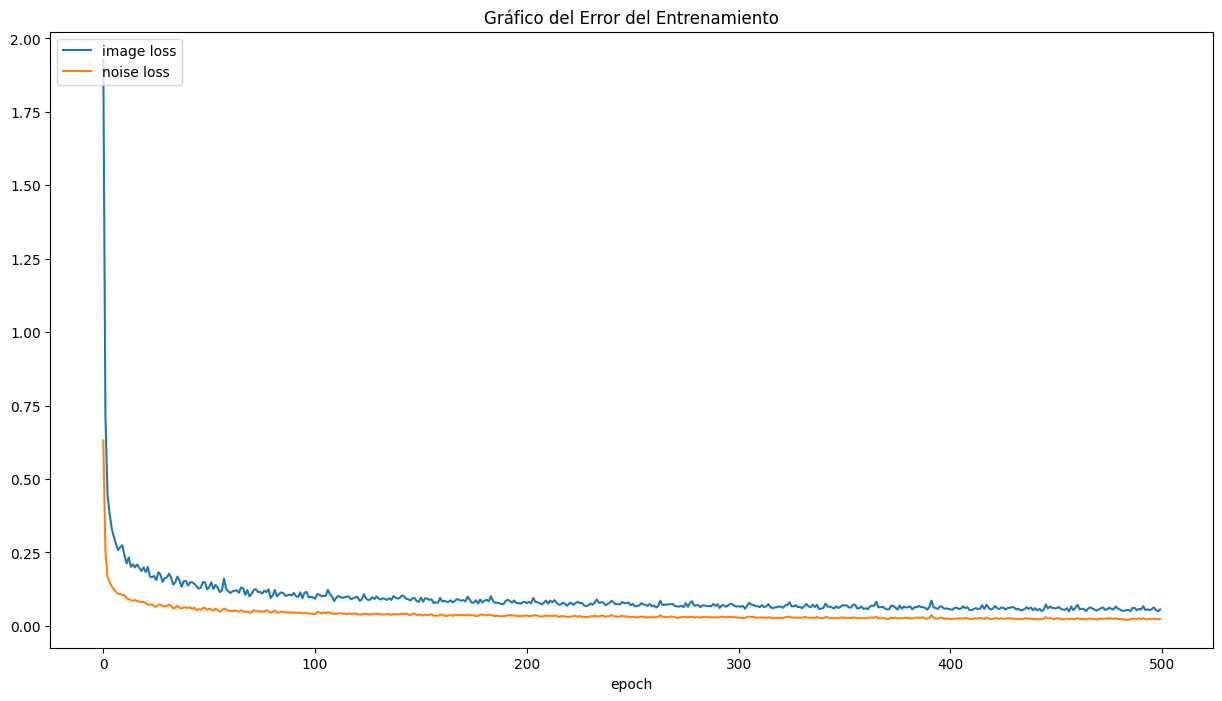

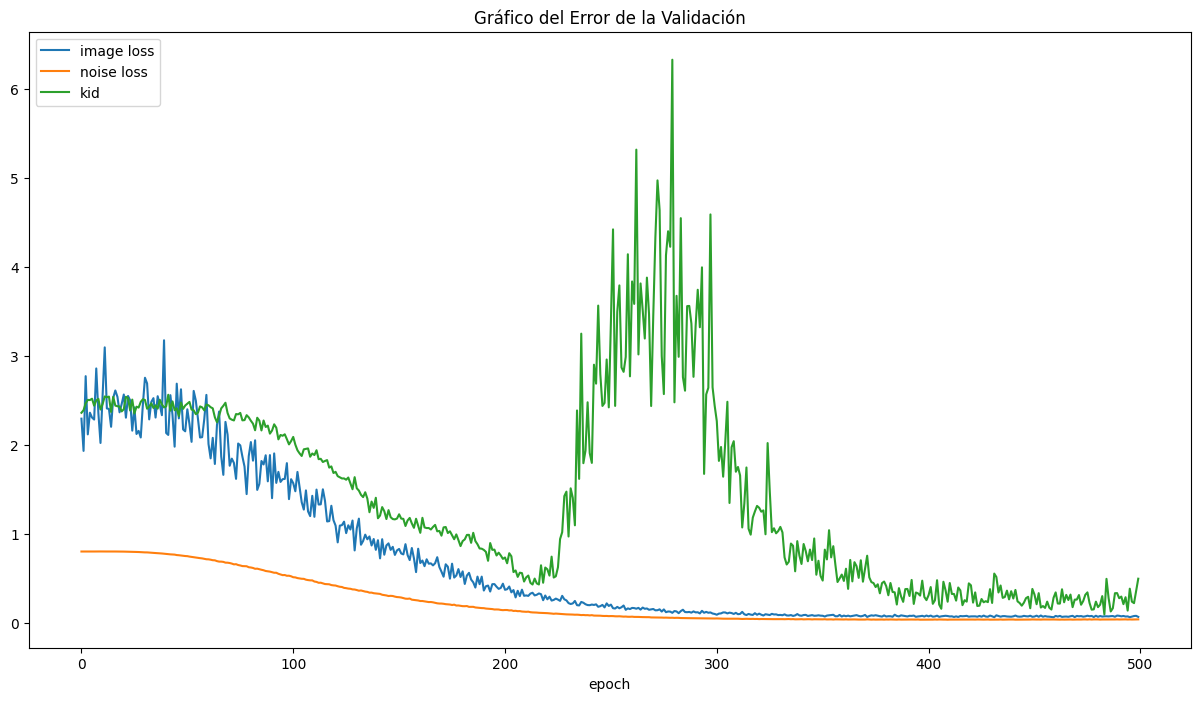

In [34]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8))
# toma valor absoluto del loss para que se muestre que baja
plt.plot(np.abs(history.history['i_loss']))
plt.plot(np.abs(history.history['n_loss']))
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['image loss', 'noise loss'], loc='upper left')
plt.show()

#@title Mostrar Gráficos de la Validación
plt.figure(figsize=(15,8))
# toma valor absoluto del loss para que se muestre que baja
plt.plot(np.abs(history.history['val_i_loss']))
plt.plot(np.abs(history.history['val_n_loss']))
plt.plot(np.abs(history.history['val_kid']))
plt.title('Gráfico del Error de la Validación')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['image loss', 'noise loss', 'kid'], loc='upper left')
plt.show()


In [35]:
#@title Mostrar evolución de imágenes generadas durante entrenamiento
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib

max_img_mostrar = 10 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
max_img_mostrar = (3 if max_img_mostrar<3 else max_img_mostrar)

# carga lista imágenes generadas
imgFN_list = list(os.listdir(path_train_images))
imgFN_list.sort()
if len(imgFN_list)>max_img_mostrar:
  print("Se encuentran más de "+str(max_img_mostrar)+" imágenes/época, se reducen para simplificar el gráfico")
  print("(en caso necesario acceder a las imágenes en " +  path_train_images + ")")
  cantPasar = len(imgFN_list)//max_img_mostrar
  auxList = []
  for i in range(max_img_mostrar):
    auxList.append( imgFN_list[i*cantPasar] )
  auxList.append( imgFN_list[len(imgFN_list)-1] )
  imgFN_list = auxList
  imgFN_list.sort()

# genera imágenes en  grilla por época
image_array = []
for fn in imgFN_list:
    if ".png" in fn:
      image = Image.open(path_train_images+"/"+fn)
      image_array.append(image)

# genera animación
fig, ax = plt.subplots()

im = ax.imshow(image_array[0], animated=True)

def update(i):
    im.set_array(image_array[i])
    return im,

animation_fig = animation.FuncAnimation(fig, update,
                                        frames=len(image_array), interval=len(image_array),
                                        blit=True, repeat=False)
plt.axis("off")
plt.tight_layout()
plt.close(fig)

# Nota: esto se agega para que funcione en Google Colab
rc('animation', html='jshtml')
display(animation_fig)


Se encuentran más de 10 imágenes/época, se reducen para simplificar el gráfico
(en caso necesario acceder a las imágenes en /content/training_images)


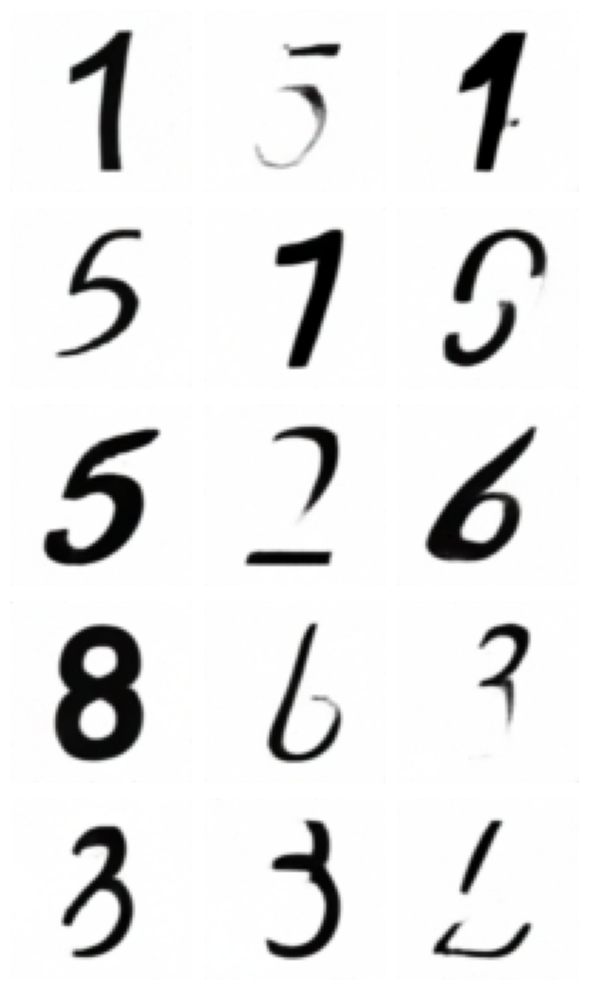

In [44]:
#@title Probar DDM  generando nuevas imágenes (modelo entrenado)

cant_img_generar = 15 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
cant_img_generar = (1 if cant_img_generar<1 else cant_img_generar)

# carga pesos
model.load_weights(last_checkpoint_path)

# genera imagenes
model.generate_images(cant_img_generar)


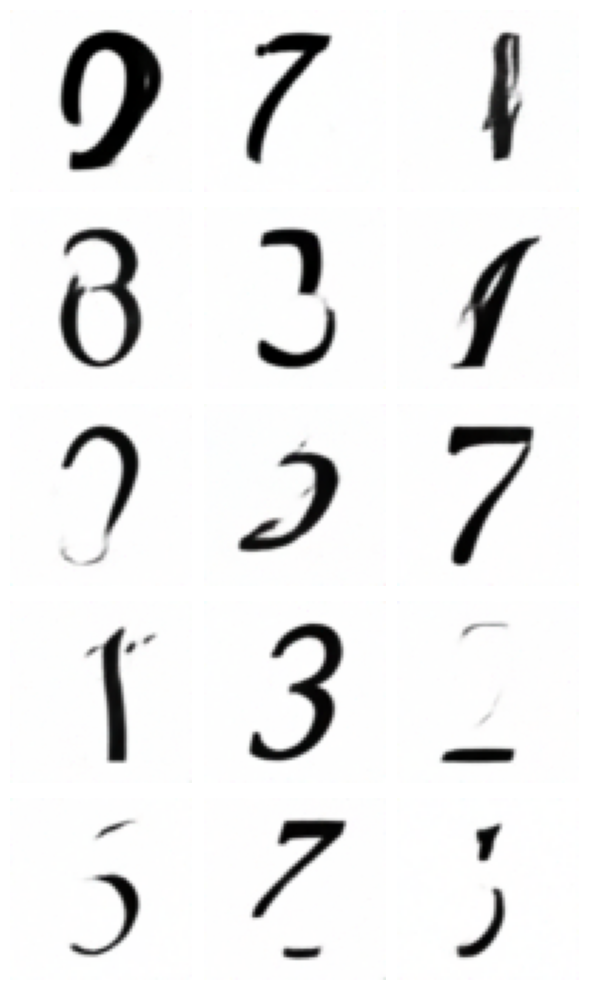

In [43]:
#@title Probar DDM  generando nuevas imágenes (mejor modelo entrenado)

cant_img_generar = 15 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
cant_img_generar = (1 if cant_img_generar<1 else cant_img_generar)

# carga pesos
model.load_weights(best_checkpoint_path)

# genera imagenes
model.generate_images(cant_img_generar)

In [47]:
#@title Guardar DDM entrenado

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoML/modelos/ImagDM'  #@param {type:"string"}


if guardar_modelo:

    import joblib
    import os
    import shutil

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_modelo = path_modelo + "/DDM.joblib"
    #joblib.dump(model, fn_modelo)
    joblib.dump(model, fn_modelo)
    print("\n- Difussion Model guardada en ", fn_modelo,"\n")

    shutil.copyfile(best_checkpoint_path, path_modelo+"/best_dm.weights.h5")
    shutil.copyfile(last_checkpoint_path, path_modelo+"/last_dm.weights.h5")
    print("\n- Checkpoints de Difussion Model guardadas\n")
else:
    print("\n-Modelo no guardado.")


- Difussion Model guardada en  /content/gdrive/MyDrive/IA/demoML/modelos/ImagDM/DDM.joblib 


- Checkpoints de Difussion Model guardadas

